In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, LeakyReLU, BatchNormalization, LSTM, Bidirectional, Input, Concatenate
from tensorflow.keras import backend
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

In [2]:
from tensorflow import keras

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
call_df=pd.read_csv('/content/drive/MyDrive/black_scholes_option_pricing/splitted_put.csv')

In [20]:

# put_df=pd.read_csv('/content/drive/MyDrive/black_scholes_option_pricing/complete_data/put_black_scholes.csv')
call_df=call_df.set_index(['Date'])
call_df=call_df[call_df['Close']>1]

In [21]:
call_df.head()

,Unnamed: 0,Unnamed: 0.1,Strike Price,Close,Expiration,Adj Close,return,volatility,Price,bs_put,implied_volatility,Moneyness_put
Date,,,,,,,,,,,,
2013-12-31,0,0,5800,6.30,30,6304.0,0.002051,0.135503,8.82,0.780877,0.401503,OTM
2013-12-31,1,1,5900,10.30,30,6304.0,0.002051,0.135503,8.82,2.667110,0.331503,OTM
2013-12-31,2,2,6000,17.15,30,6304.0,0.002051,0.135503,8.82,7.656025,0.267503,OTM
2013-12-31,3,3,6100,28.80,30,6304.0,0.002051,0.135503,8.82,18.756159,0.213503,OTM
2013-12-31,4,4,6200,49.10,30,6304.0,0.002051,0.135503,8.82,39.837882,0.172503,OTM


In [22]:
spot_df=pd.read_csv('/content/drive/MyDrive/black_scholes_option_pricing/spot_price/^NSEI.csv')
spot_df.drop(['Open','High','Low','Close','Volume'],axis=1,inplace=True)
spot_df=spot_df.set_index(['Date'])
spot_df.dropna(inplace=True)

In [23]:
spot_df.head()

,Adj Close
Date,
2013-12-02,6217.850098
2013-12-03,6201.850098
2013-12-04,6160.950195
2013-12-05,6241.100098
2013-12-06,6259.899902


In [24]:
padded = np.insert(spot_df['Adj Close'].values, 0, np.array([np.nan] * 20))

In [25]:
rolled = np.column_stack([np.roll(padded, i) for i in range(20)])

In [26]:
rolled = rolled[~np.isnan(rolled).any(axis=1)]

In [27]:
rolled = np.column_stack((spot_df[19:], rolled))

In [28]:
price_history = pd.DataFrame(data=rolled)
price_history['date']=spot_df.index[19:]
price_history=price_history.set_index(['date'])

In [29]:
joined = call_df.join(price_history,how='inner')

In [30]:
joined.head()

,Unnamed: 0,Unnamed: 0.1,Strike Price,Close,Expiration,Adj Close,return,volatility,Price,bs_put,implied_volatility,Moneyness_put,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
2013-12-31,0,0,5800,6.30,30,6304.0,0.002051,0.135503,8.82,0.780877,0.401503,OTM,6304.0,6304.0,6291.100098,6313.799805,6278.899902,6268.399902,6284.5,6274.25,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098
2013-12-31,1,1,5900,10.30,30,6304.0,0.002051,0.135503,8.82,2.667110,0.331503,OTM,6304.0,6304.0,6291.100098,6313.799805,6278.899902,6268.399902,6284.5,6274.25,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098
2013-12-31,2,2,6000,17.15,30,6304.0,0.002051,0.135503,8.82,7.656025,0.267503,OTM,6304.0,6304.0,6291.100098,6313.799805,6278.899902,6268.399902,6284.5,6274.25,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098
2013-12-31,3,3,6100,28.80,30,6304.0,0.002051,0.135503,8.82,18.756159,0.213503,OTM,6304.0,6304.0,6291.100098,6313.799805,6278.899902,6268.399902,6284.5,6274.25,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098
2013-12-31,4,4,6200,49.10,30,6304.0,0.002051,0.135503,8.82,39.837882,0.172503,OTM,6304.0,6304.0,6291.100098,6313.799805,6278.899902,6268.399902,6284.5,6274.25,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098


In [31]:
joined_ITM = joined[joined["Moneyness_put"]=="ATM"]
joined_ITM.drop(["Moneyness_put"], axis=1, inplace=True)
joined = joined_ITM

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
joined

,Unnamed: 0,Unnamed: 0.1,Strike Price,Close,Expiration,Adj Close,return,volatility,Price,bs_put,implied_volatility,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
2013-12-31,0,0,5800,6.30,30,6304.000000,0.002051,0.135503,8.820,0.780877,0.401503,6304.000000,6304.000000,6291.100098,6313.799805,6278.899902,6268.399902,6284.500000,6274.250000,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098
2013-12-31,1,1,5900,10.30,30,6304.000000,0.002051,0.135503,8.820,2.667110,0.331503,6304.000000,6304.000000,6291.100098,6313.799805,6278.899902,6268.399902,6284.500000,6274.250000,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098
2013-12-31,2,2,6000,17.15,30,6304.000000,0.002051,0.135503,8.820,7.656025,0.267503,6304.000000,6304.000000,6291.100098,6313.799805,6278.899902,6268.399902,6284.500000,6274.250000,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098
2013-12-31,3,3,6100,28.80,30,6304.000000,0.002051,0.135503,8.820,18.756159,0.213503,6304.000000,6304.000000,6291.100098,6313.799805,6278.899902,6268.399902,6284.500000,6274.250000,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098
2013-12-31,4,4,6200,49.10,30,6304.000000,0.002051,0.135503,8.820,39.837882,0.172503,6304.000000,6304.000000,6291.100098,6313.799805,6278.899902,6268.399902,6284.500000,6274.250000,6166.649902,6217.149902,6139.049805,6154.700195,6168.399902,6237.049805,6307.899902,6332.850098,6363.899902,6259.899902,6241.100098,6160.950195,6201.850098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-30,57199,57199,13650,4.55,1,13981.950195,0.003542,0.145312,5.899,0.020935,0.601312,13981.950195,13981.950195,13932.599609,13873.200195,13749.250000,13601.099609,13466.299805,13328.400391,13760.549805,13740.700195,13682.700195,13567.849609,13558.150391,13513.849609,13478.299805,13529.099609,13392.950195,13355.750000,13258.549805,13133.900391,13113.750000
2020-12-30,57200,57200,13700,5.50,1,13981.950195,0.003542,0.145312,5.899,0.111738,0.515312,13981.950195,13981.950195,13932.599609,13873.200195,13749.250000,13601.099609,13466.299805,13328.400391,13760.549805,13740.700195,13682.700195,13567.849609,13558.150391,13513.849609,13478.299805,13529.099609,13392.950195,13355.750000,13258.549805,13133.900391,13113.750000
2020-12-30,57201,57201,13750,7.35,1,13981.950195,0.003542,0.145312,5.899,0.485892,0.433312,13981.950195,13981.950195,13932.599609,13873.200195,13749.250000,13601.099609,13466.299805,13328.400391,13760.549805,13740.700195,13682.700195,13567.849609,13558.150391,13513.849609,13478.299805,13529.099609,13392.950195,13355.750000,13258.549805,13133.900391,13113.750000
2020-12-30,57202,57202,13800,9.00,1,13981.950195,0.003542,0.145312,5.899,1.736798,0.351312,13981.950195,13981.950195,13932.599609,13873.200195,13749.250000,13601.099609,13466.299805,13328.400391,13760.549805,13740.700195,13682.700195,13567.849609,13558.150391,13513.849609,13478.299805,13529.099609,13392.950195,13355.750000,13258.549805,13133.900391,13113.750000


In [32]:
call_ITM = call_df[call_df["Moneyness_put"]== "ATM"]
call_ITM = call_ITM.drop(["Moneyness_put"], axis=1)

In [33]:
# call_ITM = call[call["Moneyness_call"]== "ITM"]
# call_OTM = call[call["Moneyness_call"]== "OTM"]
# call_deep_ITM = call[call["Moneyness_call"]== "Deep ITM"]
# call_deep_OTM = call[call["Moneyness_call"]== "Deep OTM"]
# call_ATM = call[call["Moneyness_call"]== "ATM"]

In [34]:
model_df=joined.drop(['return','volatility','bs_put'],axis=1)

In [35]:
def split_data(df):
  call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(df.drop(['Close'],axis=1).values,df['Close'].values,test_size=0.2,random_state=42)
  return call_X_train, call_X_test, call_y_train, call_y_test

In [36]:
call_X_train, call_X_test, call_y_train, call_y_test=split_data(model_df)

In [37]:
call_X_train.shape

(6625, 28)

In [38]:
N_TIMESTEPS = 20

In [39]:
call_X_train = [call_X_train[:, -N_TIMESTEPS:].reshape(call_X_train.shape[0], N_TIMESTEPS, 1), call_X_train[:, :4]]
call_X_test = [call_X_test[:, -N_TIMESTEPS:].reshape(call_X_test.shape[0], N_TIMESTEPS, 1), call_X_test[:, :4]]

In [40]:
call_X_train

[array([[[10482.200195],
         [10585.200195],
         [10598.400391],
         ...,
         [10584.75    ],
         [10512.5     ],
         [10472.5     ]],
 
        [[12045.799805],
         [12113.450195],
         [12174.650391],
         ...,
         [12180.349609],
         [12106.900391],
         [12169.849609]],
 
        [[11497.900391],
         [11598.25    ],
         [11712.25    ],
         ...,
         [11604.5     ],
         [11665.950195],
         [11598.      ]],
 
        ...,
 
        [[10792.5     ],
         [10862.549805],
         [10859.900391],
         ...,
         [10601.150391],
         [10782.900391],
         [10869.5     ]],
 
        [[ 8475.75    ],
         [ 8463.099609],
         [ 8530.150391],
         ...,
         [ 8169.200195],
         [ 8090.450195],
         [ 8027.600098]],
 
        [[ 9270.900391],
         [ 9205.599609],
         [ 9293.5     ],
         ...,
         [ 8748.75    ],
         [ 8792.200195],
         [ 

In [41]:
layers = 4
n_timesteps = 20
features = 4
n_batch = 400
n_epochs = 50

In [42]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 3.7MB/s 


In [43]:
import kerastuner as kt

In [44]:
def model(hp):
    close_history = Input((n_timesteps, 1))
    input2 = Input((features,))
    
    lstm = Sequential()
    lstm.add(LSTM(units=8, input_shape=(n_timesteps, 1), return_sequences=True))
    
    for i in range(hp.Int('num_layers',2,6)):
      lstm.add(LSTM(units=hp.Int('units_'+str(i),min_value=4,max_value=16,step=2),return_sequences=True))

    
    lstm.add(LSTM(units=8,return_sequences=False))
    input1 = lstm(close_history)
    
    connect = Concatenate()([input1, input2])
    
    for _ in range(hp.Int('num_layers_dense',2,10)):
        connect = Dense(100)(connect)
        connect = BatchNormalization()(connect)
        connect = LeakyReLU()(connect)
    
    predict = Dense(1, activation='relu')(connect)

    new_model= Model(inputs=[close_history, input2], outputs=predict)
    new_model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-3, 1e-4,1e-5,1e-6])), loss='mse',metrics=['mse'])
    return new_model



In [45]:
tuner = kt.Hyperband(
    model,
    objective='mse',
    directory='/content/drive/MyDrive/black_scholes_option_pricing',
    project_name='HyperParameters',
    max_epochs=20,seed=42,
    factor=3)

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/black_scholes_option_pricing/HyperParameters/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/black_scholes_option_pricing/HyperParameters/tuner0.json


In [46]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 16, 'step': 2, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 16, 'step': 2, 'sampling': None}
num_layers_dense (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05, 1e-06], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 16, 'step': 2, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 16, 'step': 2, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 16, 'step': 2, 'sampling': None}
units_5 (Int)
{'default': None, 'cond

In [47]:
len(call_X_train)

2

In [48]:
tuner.search(call_X_train, call_y_train,epochs=20,validation_split=0.1)

INFO:tensorflow:Oracle triggered exit


In [49]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


In [50]:
best_model=tuner.hypermodel.build(best_hps)
best_model.fit(call_X_train, call_y_train, epochs=20, validation_split=0.1)

Epoch 1/20
187/187 [==============================] - 23s 48ms/step - loss: 27675.6074 - mse: 27675.6074 - val_loss: 24056.9766 - val_mse: 24056.9766
Epoch 2/20
187/187 [==============================] - 7s 37ms/step - loss: 23134.9355 - mse: 23134.9355 - val_loss: 23987.8984 - val_mse: 23987.8984
Epoch 3/20
187/187 [==============================] - 7s 36ms/step - loss: 17439.2930 - mse: 17439.2930 - val_loss: 10744.5312 - val_mse: 10744.5312
Epoch 4/20
187/187 [==============================] - 7s 37ms/step - loss: 12068.0576 - mse: 12068.0576 - val_loss: 28284.1426 - val_mse: 28284.1426
Epoch 5/20
187/187 [==============================] - 7s 36ms/step - loss: 8632.9697 - mse: 8632.9697 - val_loss: 8799.1289 - val_mse: 8799.1289
Epoch 6/20
187/187 [==============================] - 7s 37ms/step - loss: 6521.6982 - mse: 6521.6982 - val_loss: 13605.2168 - val_mse: 13605.2168
Epoch 7/20
187/187 [==============================] - 7s 36ms/step - loss: 5913.9146 - mse: 5913.9146 - val_los

In [51]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8)            4088        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 12)           0           sequential[0][0]                 
                                                                 input_2[0][0]                

In [52]:
y_pred_new=best_model.predict(call_X_test)
y_pred_new.shape

(1657, 1)

In [53]:
y_pred_new

array([[192.10747],
       [ 93.45963],
       [419.33603],
       ...,
       [238.35454],
       [155.8851 ],
       [281.05765]], dtype=float32)

In [54]:
y_pred_train=best_model.predict(call_X_train)

In [55]:
y_pred_train.shape

(6625, 1)

In [56]:
call_X_train_tm, call_X_test_tm, call_y_train_tm, call_y_test_tm = train_test_split(call_ITM.drop(['Close'],axis=1),call_ITM['bs_put'],test_size=0.2,random_state=42)

In [57]:
call_y_test_tm

Date
2018-10-15    233.884997
2017-09-06     69.218632
2020-04-24    632.077964
2016-10-19     61.872254
2018-07-18     64.478627
                 ...    
2015-01-21    195.567775
2020-07-16    103.549904
2014-04-23    100.734387
2014-08-08     94.871494
2020-08-31    170.637105
Name: bs_put, Length: 1657, dtype: float64

In [58]:
# y_pred_new.shape
y_pred_old = (call_X_test_tm["bs_put"])
for i in range(len(y_pred_old)):
  if pd.isnull(y_pred_old[i]):
    y_pred_old[i] = 0
    y_pred_new[i] = 0


In [59]:
from sklearn.metrics import r2_score
r2_score( y_pred_old ,y_pred_new)

0.2442389901525942

In [60]:
x=np.array(call_y_test).reshape(-1,1)
y=np.array(y_pred_new).reshape(-1,1)
reg=LinearRegression().fit(x,y_pred_new)
mae= mean_absolute_error(x,y_pred_new)
print(reg.score(x,y_pred_new),mae)

0.5670097708787956 45.78919763969382


In [61]:
r2_score(call_y_train,y_pred_train)


0.5746005624856018

In [62]:
call_X_test_tm["bs_put"]

Date
2018-10-15    233.884997
2017-09-06     69.218632
2020-04-24    632.077964
2016-10-19     61.872254
2018-07-18     64.478627
                 ...    
2015-01-21    195.567775
2020-07-16    103.549904
2014-04-23    100.734387
2014-08-08     94.871494
2020-08-31    170.637105
Name: bs_put, Length: 1657, dtype: float64

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print('mse:',mean_squared_error(call_y_test ,y_pred_new))

print('mae:',mean_absolute_error(call_y_test ,y_pred_new))

mse: 5065.4136339861225
mae: 45.78919763969382


In [64]:
from sklearn.metrics import mean_absolute_error
for i in range(len(call_y_test_tm)):
  if pd.isnull(call_y_test_tm[i]):
    call_y_test_tm[i] = 0
    call_y_test[i] = 0

mean_absolute_error(call_y_test ,call_y_test_tm)

45.44739126166029

In [65]:
mean_squared_error(call_y_test ,call_y_test_tm)

6744.85763658044

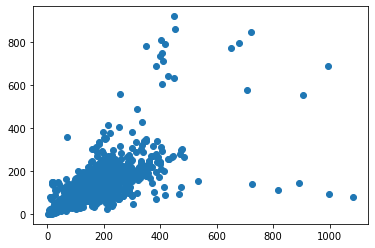

In [66]:
x=np.array(call_y_test).reshape(-1,1)
y=np.array(call_y_test_tm).reshape(-1,1)
reg=LinearRegression().fit(x,y)
mae= mean_absolute_error(x,y)
plt.scatter(x,y)

In [67]:
best_model.save('/content/drive/MyDrive/black_scholes_option_pricing/HyperParameters/lstm_model.h5')